(feature-extraction)=
# 特徴量抽出

In [1]:
# シードの固定
import random
import numpy as np
random.seed(31415)
np.random.seed(31415)

さて、今回からは数字ではなく「ひらがな」のデータセットを用いて、より複雑な識別問題に取り組む。

データセットは国立国会図書館の[NDLラボ](https://lab.ndl.go.jp/)が公開している文字画像データセットを使用する。

- 文字画像データセット: <https://github.com/ndl-lab/hiragana_mojigazo>

実際のデータセットは、以下のURLにホストされているので、ここからダウンロードする。

**文字画像データセット(平仮名73文字版) (zip形式)** 

- <http://lab.ndl.go.jp/dataset/hiragana73.zip>

In [2]:
import os
import sys

import requests
from tqdm.notebook import tqdm

url = "http://lab.ndl.go.jp/dataset/hiragana73.zip"
filename = os.path.basename(url)

# データ格納用のディレクトリを作る
os.makedirs("data", exist_ok=True)

# HTTPリクエストを送ってデータサイズを取得
r = requests.get(url, stream=True)
total_size = int(r.headers.get("content-length", 0))
chunk_size = 65535

# 実際のファイルのダウンロード
pbar = tqdm(total=total_size, unit="B", unit_scale=True)
with open(filename, "wb") as f:
    for data in r.iter_content(chunk_size):
        f.write(data)
        pbar.update(chunk_size)

  0%|          | 0.00/233M [00:00<?, ?B/s]

In [3]:
# ダウンロードが完了したらZIPを展開する
import zipfile

with zipfile.ZipFile(filename, "r") as f:
    f.extractall()

## データセットの前処理

このデータセットは濁音、半濁音を含むひらがな73文字に対して、そのUnicode値のフォルダの中に、48×48の画像がPNG形式で保存されている。

各ひらがなのUnicode値を調べるには、`ord`関数を用いてUnicode値に変換した後に、それを`hex`関数を用いて16進数表記の文字列に変換すれば良い。

一例として「あ」であれば、以下のようにUnicode値を得ることができる。

In [4]:
a = "あ"
hira_a = hex(ord(a))
print(hira_a)

0x3042


逆に、あいうえお順で文字を取得したければ、「あ」に対応するUnicode値である`0x3042`からスタートして、1ずつ値を上げていきながら、その数字を`chr`関数を用いて文字に変換すれば良い。

なお、16進数の文字列を整数に直したいときには、`int(hira_a)`と単に文字列を渡すだけではダメで、第2引数に何進数の数字なのかを与えて `int(hira_a, 16)` のようにする必要があることに注意すること。

上記のひらがなデータセットは「ゃ」や「っ」などの小文字を含まない73文字から構成されているが、「あ」から「ん」までは、小文字を含め82文字なので、これを列挙してみる。

In [5]:
for i in range(82):
    print(chr(int(hira_a, 16) + i), end="")

あぃいぅうぇえぉおかがきぎくぐけげこごさざしじすずせぜそぞただちぢっつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽまみむめもゃやゅゆょよらりるれろゎわゐゑをん

ひらがなデータセットのフォルダ名は16進数を表わす`0x`の代わりに`U`が接頭辞になっているので、フォルダ名の`U`を`0x`に置換して、どの文字がデータセットに含まれているかをチェックしてみる。

In [6]:
# サブフォルダの数を調べる
dirname = "hiragana73"
folders = sorted([d for d in os.listdir(dirname)])
print('There are {:d} folders in "{:s}".'.format(len(folders), dirname))

# フォルダに対応する文字を列挙
for d in folders:
    x = d.replace("U", "0x")
    print(chr(int(x, 16)), end="")

There are 73 folders in "hiragana73".
あいうえおかがきぎくぐけげこごさざしじすずせぜそぞただちぢつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽまみむめもやゆよらりるれろわゐゑをん

さらに、各文字に何個ずつ画像が含まれているかもチェックしておこう。

In [7]:
import numpy as np
import pandas as pd
from IPython import display

chars = [chr(int(d.replace("U", "0x"), 16)) for d in folders]
dir_paths = [os.path.join(dirname, d) for d in folders]
num_images = [len(os.listdir(d)) for d in dir_paths]

df = pd.DataFrame([(c, n) for c, n in zip(chars, num_images)])
sub_dfs = [df[i : i + 10].reset_index(drop=True) for i in range(0, len(df.index), 10)]
df = pd.concat(sub_dfs, axis=1).fillna("")

df.index = [i for i in range(len(df.index))]
df.columns = [j for j in range(len(df.columns))]


def custom_style(df):
    index = df.index
    columns = df.columns
    styles = []
    for i in range(len(index)):
        s = []
        for j in range(len(columns)):
            if columns[j] % 2 == 0:
                s.append("font-weight: bold;")
            else:
                s.append(None)
        styles.append(s)

    return np.array(styles, dtype="object")


df.style.format(precision=0).format_index("", axis=1).format_index("", axis=0).apply(
    custom_style, axis=None
)

,,,,,,,,,,,,,,,,
,あ,1208,ぐ,1043,ず,1046,づ,1080,は,1247,べ,1109,や,1285,ゑ,1030
,い,1122,け,1155,せ,1165,て,1213,ば,1105,ぺ,268,ゆ,1282,を,1254
,う,1148,げ,1058,ぜ,1115,で,1178,ぱ,262,ほ,1115,よ,1166,ん,1285
,え,1077,こ,1115,そ,1285,と,1184,ひ,1074,ぼ,1044,ら,1114,,
,お,1283,ご,1078,ぞ,1066,ど,1134,び,1045,ぽ,261,り,1244,,
,か,1259,さ,1261,た,1285,な,1233,ぴ,126,ま,1285,る,1190,,
,が,1200,ざ,1070,だ,1116,に,1260,ふ,1285,み,1142,れ,1238,,
,き,1121,し,1285,ち,1052,ぬ,1093,ぶ,1149,む,1058,ろ,1069,,
,ぎ,1091,じ,1099,ぢ,1132,ね,1126,ぷ,112,め,1233,わ,1283,,
,く,1266,す,1282,つ,1142,の,1160,へ,1114,も,1187,ゐ,1053,,


このように、ひらがなについて、おおよそ1000程度の画像が含まれていることが確認できる。なお、半濁音のひらがなは全体的に少なめで100-200程度となっている。

### 分類用のデータ加工

MNISTでは手書き文字の画像が28x28=576次元ベクトル、ラベルが10種類の数字のいずれかを表わす0-9の数字であった。

このようなデータ形式をひらがなデータセットに対しても作成しておく。なお、今回は分類の難易度を上げるため、**画像をランダムに回転したり、拡大縮小したりして、データのばらつきを大きくしておく**。

In [8]:
# 文字への整数の割り当て
n_chars = len(chars)
char2num = {c: i for i, c in enumerate(chars)}

In [9]:
import cv2

n_total = sum(num_images)
pbar = tqdm(total=n_total)

# 画像の読み取り
X = []  # 画像データ
y = []  # ラベルデータ
for d in dir_paths:
    # 文字に対する数字を計算
    char = os.path.basename(d).replace("U", "0x")
    char = chr(int(char, 16))
    num = char2num[char]
    # 画像の読み込み
    image_files = [os.path.join(d, f) for f in os.listdir(d)]
    image_files = [f for f in image_files if f.endswith(".png")]
    for f in image_files:
        image = cv2.imread(f, cv2.IMREAD_COLOR)
        if image is None:
            raise IOError("Failed to load image: {:s}".format(f))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # データのランダム回転、ランダムスケール
        height, width = image.shape
        center = (width // 2, height // 2)
        scale = np.random.uniform(0.95, 1.05)
        angle = np.random.uniform(-180, 180)
        trans = cv2.getRotationMatrix2D(center, angle, scale)
        image = cv2.warpAffine(image, trans, (width, height), borderMode=cv2.BORDER_REPLICATE)
        
        X.append(image.flatten())
        y.append(num)

        pbar.update(1)

  0%|          | 0/80000 [00:00<?, ?it/s]

読み込みが完了したら例のごとく訓練データとテストデータに分割しておく。今回は画像が80000枚あるので、60000枚を訓練画像、20000枚をテスト画像とする。

In [10]:
from sklearn import model_selection

X, X_test, y, y_test = model_selection.train_test_split(
    X, y, train_size=60000, test_size=10000, shuffle=True
)

データセットの先頭5枚の画像は次のようになっている。

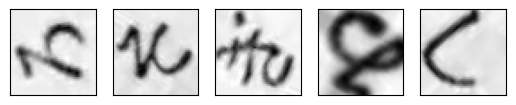

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5)
for i in range(5):
    axs[i].imshow(X[i].reshape((48, 48)), cmap="gray")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

### 実験: 線形回帰による分類

まずは、MNISTの時と同様にscikit-learnによる分類を試してみる。

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {"max_depth": 5, "n_estimators": 20, "max_features": 8}

clf = RandomForestClassifier(**rf_params)
clf.fit(X, y)

RandomForestClassifier(max_depth=5, max_features=8, n_estimators=20)

In [37]:
# 訓練時の識別精度の確認
y_pred = clf.predict(X)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("Logistic: acc(train)={:.2f}%".format(acc_train))

Logistic: acc(train)=24.15%


In [38]:
# テストデータに対する識別精度の計算
y_pred = clf.predict(X_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Logistic: acc(test)={:.2f}%".format(acc_test))

Logistic: acc(test)=20.52%


もちろん、これはこれで悪くはなく、訓練やテストに十分時間がかけられるのなら、十分実用的だろう。しかし、48x48の画像をそのまま2304次元のベクトルとするのは、少々効率が悪く、例えば画像の中から物体を検知したい場合などは、画像の一部を切り出す窓を移動しながら、識別を繰り返し行うために多大な計算時間が必要になってしまう。

### 輝度によるヒストグラム化

まず、非常に単純なアイディアとして画像の輝度を基準としたヒストグラム化を考えてみる。今、画像は256階調の輝度で表わされているので、輝度のヒストグラムを作ることで、どれほど大きな画像であっても256次元のベクトルにすることができる。

In [15]:
H = []
for x in tqdm(X):
    h = np.histogram(x, bins=255, density=True)
    H.append(h[0])

  0%|          | 0/60000 [00:00<?, ?it/s]

In [16]:
clf2 = RandomForestClassifier(**rf_params)
clf2.fit(H, y)

RandomForestClassifier(max_depth=10, max_features=8, n_estimators=50)

In [17]:
# 訓練時の識別精度の確認
y_pred = clf2.predict(H)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("Logistic: acc(train)={:.2f}%".format(acc_train))

Logistic: acc(train)=31.25%


In [18]:
H_test = []
for x in tqdm(X_test):
    h = np.histogram(x, bins=255, density=True)
    H_test.append(h[0])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [19]:
# テストデータに対する識別精度の計算
y_pred = clf2.predict(H_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Logistic: acc(test)={:.2f}%".format(acc_test))

Logistic: acc(test)=3.39%


しかし、実際に試してみると上記のように満足な精度が得られるには至っていない。これは、ほとんどの画像がほぼ同じ割合の白と黒の領域でできていて、それをヒストグラム化してしまうと、文字の分類が難しくなるためである。従って、もう少し気の利いた方法を考える必要がある。

### Local Binary Pattern

Local Binary Pattern (LBP)は、とある画素を中心とした3x3の領域について、中心画素と周りの画素の輝度の大小を数値化する手法である {cite}`ojala1996comparative`。

一例として、とある中心画素周辺の画素値が以下のようになっている場合を考えよう。

In [20]:
import matplotlib.pyplot as plt


def draw_frame(problem, fig, ax):
    mask = (problem == 0).astype("float32")
    frame = []
    ax.set_xticks(np.arange(0, 9))
    ax.set_yticks(np.arange(0, 9))
    ax.set_xticklabels(np.arange(1, 10))
    ax.set_yticklabels(np.arange(1, 10))

    ax.set_xticks(np.arange(1, 10) - 0.5, minor=True)
    ax.set_yticks(np.arange(1, 10) - 0.5, minor=True)
    ax.set_xticks(np.arange(3, 10, 3) - 0.5)
    ax.set_yticks(np.arange(3, 10, 3) - 0.5)

    ims = plt.imshow(mask * 0.2, cmap="Blues", vmin=0.0, vmax=1.0)
    frame.append(ims)
    for (i, j), z in np.ndenumerate(problem):
        txt = ax.text(j, i, "{:d}".format(z), ha="center", va="center", color="k", fontsize=15)
        frame.append(txt)

    ax.grid(which="minor", color="k", linestyle="-", linewidth=0.5)
    ax.grid(which="major", color="k", linestyle="-", linewidth=1.0)

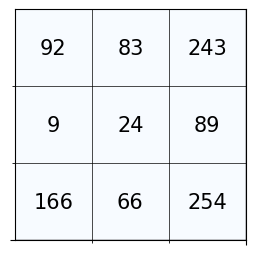

In [21]:
m = np.random.randint(0, 256, size=(3, 3))
fig, ax = plt.subplots(figsize=(3, 3))
draw_frame(m, fig, ax)

このとき、中心画素と周囲の8画素の大小を見比べて、大きいものを1, 小さいものを0に置き換える。

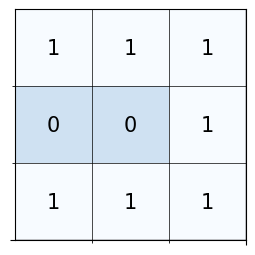

In [22]:
c = m[1, 1]
b = (m > c).astype("int32")
fig, ax = plt.subplots(figsize=(3, 3))
draw_frame(b, fig, ax)

この周囲の8画素に割り当てられた0, 1のパターンが8ビットの符号なし整数であると考えて数値を求める。このとき、以下のような時計回りに2のべき乗が並んだ画像を用いると良い。

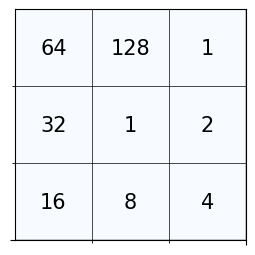

In [23]:
p = 2 ** np.array([[6, 7, 0], [5, 0, 1], [4, 3, 2]])

fig, ax = plt.subplots(figsize=(3, 3))
draw_frame(p, fig, ax)

In [24]:
from IPython.display import Markdown

Markdown(f"すると、上記の3x3の領域に対しては、LBPの値として**{np.sum(b * p):d}**が求まる")

すると、上記の3x3の領域に対しては、LBPの値として**223**が求まる

In [25]:
lbp = np.sum(b * p)
print("LBP={:d}".format(lbp))

LBP=223


この計算を以下の画像の各画素に対して行ってみる。

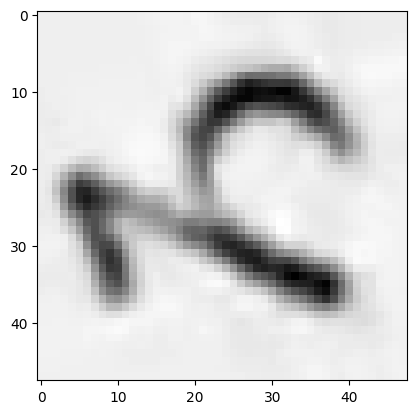

In [26]:
im = X[0].reshape((48, 48))
im = cv2.GaussianBlur(im, None, sigmaX=0.5)

plt.imshow(im, cmap="gray")
plt.show()

In [27]:
lbp = np.zeros_like(im).astype("uint8")
for j in range(1, im.shape[0] - 1):
    for i in range(1, im.shape[1] - 1):
        c = im[i, j]
        m = im[i - 1 : i + 2, j - 1 : j + 2]
        b = (m > c).astype("int32")
        lbp[i, j] = np.sum(p * b)

# 輪郭の画素では計算できないので、輪郭を除いておく
lbp = lbp[1:-1, 1:-1]

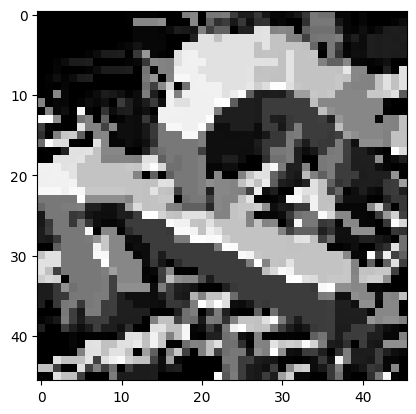

In [28]:
plt.imshow(lbp, cmap="gray")
plt.show()

これを先ほどと同じようにヒストグラム化すると、以下のようになる (以下の画像は分かりやすさのためにbinの数を32個にしてある)。

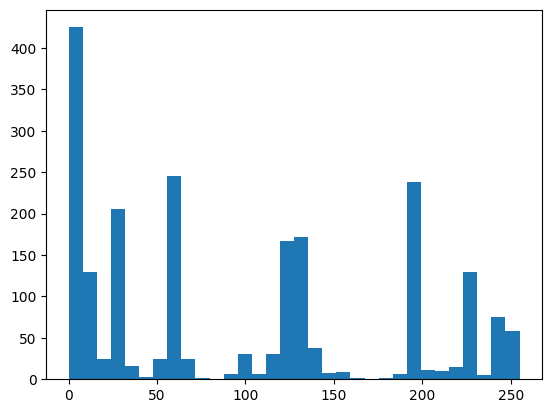

In [29]:
plt.hist(lbp.flatten(), bins=32)
plt.show()

LBPを用いることの利点は画像の相対的な輝度だけを見ている点にあり、仮に画像の輝度が2倍になったりしても求まるLBPの値は全く変化しない。そのため、同じ対象を異なる光源下で計算した場合などに一貫した特徴を得られる。

In [30]:
from sklearn.feature_extraction.image import extract_patches_2d


def calc_lbp(x):
    x = cv2.GaussianBlur(x, None, sigmaX=0.5)
    pat = (2 ** np.array([[0, 1, 2], [7, 0, 3], [6, 5, 4]])).astype("int32")

    patches = extract_patches_2d(x, (3, 3))
    centers = patches[:, 1, 1].reshape((-1, 1, 1))
    binary = (patches > centers).astype("int32")

    return np.sum(binary * pat.reshape((1, 3, 3)), axis=(1, 2))


def calc_lbp_hist(x):
    lbp = calc_lbp(x)
    return np.histogram(lbp, bins=255, density=True)[0]


L = [calc_lbp_hist(x.reshape((48, 48))) for x in tqdm(X)]

  0%|          | 0/60000 [00:00<?, ?it/s]

In [31]:
clf3 = RandomForestClassifier(**rf_params)
clf3.fit(L, y)

RandomForestClassifier(max_depth=10, max_features=8, n_estimators=50)

In [32]:
# 訓練時の識別精度の確認
y_pred = clf3.predict(L)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("Logistic: acc(train)={:.2f}%".format(acc_train))

Logistic: acc(train)=44.64%


In [33]:
L_test = [calc_lbp_hist(x.reshape((48, 48))) for x in tqdm(X_test)]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [34]:
# テストデータに対する識別精度の計算
y_pred = clf3.predict(L_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Logistic: acc(test)={:.2f}%".format(acc_test))

Logistic: acc(test)=9.37%
